In [18]:
from qiskit import QuantumCircuit,transpile 
from qiskit_aer import AerSimulator,StatevectorSimulator,QasmSimulator
from qiskit.circuit.library import RZGate,RXGate 
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector,plot_distribution,plot_histogram

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

from qiskit_ibm_runtime import Session 

from qiskit.primitives import Estimator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient

from tabulate import tabulate
from qiskit_algorithms.gradients import QFI
from qiskit_algorithms.gradients import DerivativeType, LinCombQGT

estimator=Estimator()
from qiskit.circuit import Parameter
import numpy as np
from qiskit.primitives import Estimator

from qiskit.quantum_info import hellinger_distance,hellinger_fidelity,state_fidelity

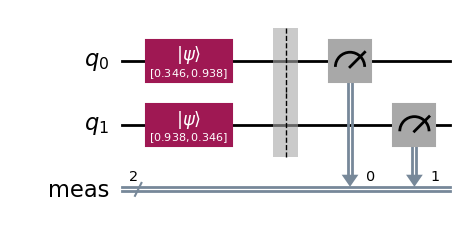

In [2]:
qc=QuantumCircuit(2)
seed=np.random.random()


alpha=np.sqrt(seed)
beta=np.sqrt(1-seed)

qc.initialize([alpha,beta],[0])
qc.initialize([beta,alpha],[1])

qc.measure_all()

qc.draw(output="mpl")

In [3]:
qc.remove_final_measurements()
zeros=Statevector.from_label("00")
sv_a=zeros.evolve(qc)

sv_a.draw(output="latex")

<IPython.core.display.Latex object>

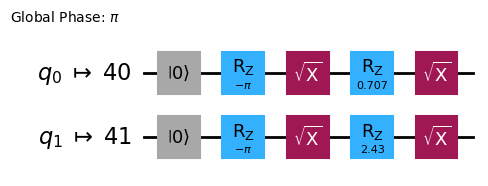

In [4]:
service=QiskitRuntimeService()
backend=service.least_busy(operational=True,simulator=False)
pm=generate_preset_pass_manager(backend=backend,optimization_level=2)

opt_qc=pm.run(qc)

opt_qc.draw(output="mpl",idle_wires=False)

**Imitating the Transpiled Circ as a Quantum Circuit Object, to reduce the burden of idle qubits**

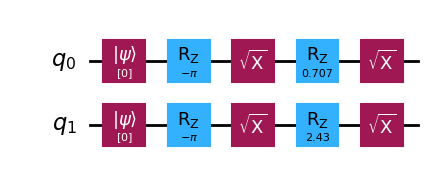

In [5]:
staged_circ=QuantumCircuit(2)
staged_circ.initialize(0,0)
staged_circ.initialize(0,1)

staged_circ.rz(-np.pi,0)
staged_circ.sx(0)

staged_circ.rz(0.707,0)
staged_circ.sx(0)

staged_circ.rz(-np.pi,1)
staged_circ.sx(1)
staged_circ.rz(2.43,1)
staged_circ.sx(1)

staged_circ.draw(output="mpl")

In [6]:
zeros=Statevector.from_label("00")
sv=zeros.evolve(staged_circ)

sv.draw(output="latex")

<IPython.core.display.Latex object>

Note the inverted global phase in sign. However, this is irrelevant.

In [7]:
print(f"State Fidelity of Transpiled and Initialized Circuit: {state_fidelity(sv_a,sv):.8f}")

State Fidelity of Transpiled and Initialized Circuit: 0.99999442


$\textbf{Comment:}$ The Statevectors do not exactly match in the initialized and the Transpiled Circuits for the Non Uniform State.

In [13]:
master_params=[-np.pi,0.707,-np.pi,2.43]

In [14]:
def get_fisher(qc,param_list):
    master_param=[param_list]
    qgt = LinCombQGT(estimator, derivative_type=DerivativeType.REAL)

    qgt_result = qgt.run(qc, master_param).result().qgts

    qfi = QFI(qgt)
    qfi_result = qfi.run(qc, master_param).result().qfis

    return qfi_result[0]

In [15]:
# Initializing excess parameters for housekeeping
param_list=[]
for i in range (11):
    param_list.append(Parameter(f"x_{i}"))
print("Displaying initialized parameters:",*param_list,sep="\n")

Displaying initialized parameters:
x_0
x_1
x_2
x_3
x_4
x_5
x_6
x_7
x_8
x_9
x_10


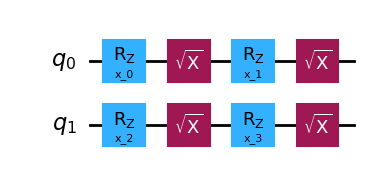

In [16]:
fisher_circ=QuantumCircuit(2)

fisher_circ.rz(param_list[0],0)
fisher_circ.sx(0)
fisher_circ.rz(param_list[1],0)
fisher_circ.sx(0)


fisher_circ.rz(param_list[2],1)
fisher_circ.sx(1)
fisher_circ.rz(param_list[3],1)
fisher_circ.sx(1)

fisher_circ.draw(output="mpl")

In [17]:
print("Displaying the Quantum Fisher Matrix for the Non Uniform State Embedding Circuit: ")

qfi_result=get_fisher(fisher_circ,master_params)
print(tabulate(qfi_result,tablefmt="grid"))

Displaying the Quantum Fisher Matrix for the Non Uniform State Embedding Circuit: 
+-------------+-------------+-------------+-------------+
| 3.33067e-16 | 7.10196e-17 | 3.33067e-16 | 4.3505e-17  |
+-------------+-------------+-------------+-------------+
| 7.10196e-17 | 1           | 7.10196e-17 | 5.55112e-17 |
+-------------+-------------+-------------+-------------+
| 3.33067e-16 | 7.10196e-17 | 3.33067e-16 | 4.3505e-17  |
+-------------+-------------+-------------+-------------+
| 4.3505e-17  | 5.55112e-17 | 4.3505e-17  | 1           |
+-------------+-------------+-------------+-------------+
